In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from env import api_key
import requests
import json
from acquire import *
from bs4 import BeautifulSoup
import os
import re
from prepare import *
import IPython
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler

In [2]:
df = pd.read_csv("sponsor_and_co_df.csv")

In [3]:
df.head()

,sponsor,party,bill_text,sponsor_state,cosponsor,cosponsor_party,cosponsor_state,other_bill_date
0,"Torres Small, Xochitl",D,<body><pre>\n[Congressional Bills 116th Congre...,NM,"Crenshaw, Dan",R,TX,2020-02-06
1,"Sewell, Terri A.",D,<body><pre>\n[Congressional Bills 116th Congre...,AL,"Smith, Adrian",R,NE,2020-02-03
2,"Finkenauer, Abby",D,<body><pre>\n[Congressional Bills 116th Congre...,IA,NaN,NaN,NaN,2020-02-03
3,"Casten, Sean",D,<body><pre>\n[Congressional Bills 116th Congre...,IL,"Levin, Mike",D,CA,2020-02-03
4,"LaMalfa, Doug",R,<body><pre>\n[Congressional Bills 116th Congre...,CA,NaN,NaN,NaN,2020-02-03


In [4]:
df = prepare_bills_for_processing(df)

In [5]:
df['lem'] = df.bill_text.apply(clean_text)

In [6]:
df['model'] = df.lem.apply(join)

In [7]:
df.head()

,sponsor,party,bill_text,sponsor_state,cosponsor,cosponsor_party,cosponsor_state,other_bill_date,lem,model
0,"Torres Small, Xochitl",D,\n\n\n \n To require the Secretary of Homelan...,NM,"Crenshaw, Dan",R,TX,2020-02-06,"[require, homeland, security, develop, plan, i...",require homeland security develop plan increas...
1,"Sewell, Terri A.",D,\n\n\n \nTo amend title XI of the Social Secur...,AL,"Smith, Adrian",R,NE,2020-02-03,"[amend, xi, social, security, clarify, paramet...",amend xi social security clarify parameter mod...
2,"Finkenauer, Abby",D,\n\n\n \n To repeal the funding authorization ...,IA,NaN,NaN,NaN,2020-02-03,"[repeal, funding, sunset, total, funding, cap,...",repeal funding sunset total funding cap americ...
3,"Casten, Sean",D,\n\n\n \nTo direct the Federal Energy Regulato...,IL,"Levin, Mike",D,CA,2020-02-03,"[direct, federal, energy, regulatory, commissi...",direct federal energy regulatory commission fi...
4,"LaMalfa, Doug",R,\n\n\n \n To establish a categorical exclusio...,CA,NaN,NaN,NaN,2020-02-03,"[exclusion, electric, utility, rightsof, way, ...",exclusion electric utility rightsof way purpos...


In [227]:
def partisan_viz(df):
    df['cosponsor_party'] = df['cosponsor_party'].fillna('N')
    bipart_df = pd.DataFrame(df['party'].value_counts())
    bipart_df.rename(columns = {'party': 'total_bills'}, inplace = True)
    bipart_counts = df[df['party'] != (df['cosponsor_party'])]['party'].value_counts()
    no_co_counts = df[df['cosponsor_party'] == 'N']['party'].value_counts()
    bipart_df['bipart_bills'] = (bipart_counts - no_co_counts)
    bipart_df['partisan_bills'] = df[df['party'] == (df['cosponsor_party'])]['party'].value_counts()
    bipart_df['no_cosponsor'] = df[df['cosponsor_party'] == 'N']['party'].value_counts()
    bipart_df.reset_index(inplace = True)
    bipart_df.rename(columns = {'index':'party'}, inplace = True)
    bipart_df.drop(columns = ['total_bills'], inplace = True)
    
    pal = ({"bipart_bills":'cornflowerblue', 
            "partisan_bills":"royalblue", "no_cosponsor":"lightsteelblue"})
    vz = bipart_df.head(2).plot(kind="bar", figsize = (5, 4), x = 'party', color = pal)
    vz.set(ylabel="Number of Bills",
           xlabel="Party", title = 'Partisan vs Bipartisan Bill Breakdown')
    vz.set_xticklabels(['Democrat', 'Republican'])
    vz.legend(["Bipartisan Bills", "Partisan Bills", "No Cosponsor"])
    plt.xticks(rotation='horizontal')
    return plt.show()



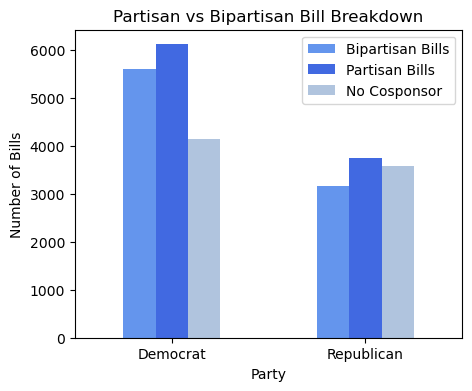

In [228]:
partisan_viz(df)

In [224]:
bipart_df = pd.DataFrame(df['party'].value_counts())
bipart_df.rename(columns = {'party': 'total_bills'}, inplace = True)
bipart_df

,total_bills
D,15888
R,10482
I,150
L,13


In [174]:
bipart_true

D    5614
R    3168
I      85
L       1
Name: party, dtype: int64

In [152]:
bipart_df['bipart_bills'] = bipart_counts
bipart_df

,total_bills,bipart_bills
D,15888,9769
R,10482,6740
I,150,149
L,13,13


In [153]:
no_co_counts = df[df['cosponsor_party'] == 'N']['party'].value_counts()
partisan_counts = df[df['party'] == (df['cosponsor_party'])]['party'].value_counts()

In [154]:
bipart_df['partisan_bills'] = partisan_counts

In [155]:
bipart_df['no_cosponsor'] = no_co_counts

In [156]:
bipart_df.reset_index(inplace = True)
bipart_df

,index,total_bills,bipart_bills,partisan_bills,no_cosponsor
0,D,15888,9769,6119.0,4155
1,R,10482,6740,3742.0,3572
2,I,150,149,1.0,64
3,L,13,13,NaN,12


In [157]:
bipart_df.rename(columns = {'index':'party'}, inplace = True)

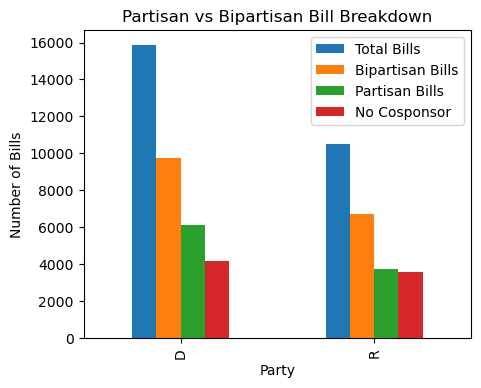

In [162]:
vz = bipart_df.head(2).plot(kind="bar", figsize = (5, 4), x = 'party')
vz.set(ylabel="Number of Bills",
       xlabel="Party", title = 'Partisan vs Bipartisan Bill Breakdown')
vz.legend(["Total Bills", "Bipartisan Bills", "Partisan Bills", "No Cosponsor"])
plt.show()